In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We can see there few data for columns Glucose, Insulin, skin thickness, BMI and Blood Pressure which have value as 0. That's not possible. You can do a quick search to see that one cannot have 0 values for these.

In [7]:
#Replacing zero values with mean of the column
data['BMI'] = data['BMI'].replace(0,data['BMI'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0,data['BloodPressure'].mean())
data['Glucose'] = data['Glucose'].replace(0,data['Glucose'].mean())
data['Insulin'] = data['Insulin'].replace(0,data['Insulin'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0,data['SkinThickness'].mean())

In [14]:
# Handling the Outliers

q1 = data['Pregnancies'].quantile(0.98)
# we are removing the top 2% data from the Pregnancies column
data_cleaned = data[data['Pregnancies']<q1]
q2 = data_cleaned['BMI'].quantile(0.99)
# we are removing the top 1% data from the BMI column
data_cleaned  = data_cleaned[data_cleaned['BMI']<q2]
q3 = data_cleaned['SkinThickness'].quantile(0.99)
# we are removing the top 1% data from the SkinThickness column
data_cleaned  = data_cleaned[data_cleaned['SkinThickness']<q3]
q4 = data_cleaned['Insulin'].quantile(0.95)
# we are removing the top 5% data from the Insulin column
data_cleaned  = data_cleaned[data_cleaned['Insulin']<q4]
q5 = data_cleaned['DiabetesPedigreeFunction'].quantile(0.99)
# we are removing the top 1% data from the DiabetesPedigreeFunction column
data_cleaned  = data_cleaned[data_cleaned['DiabetesPedigreeFunction']<q4]
q6 = data_cleaned['Age'].quantile(0.99)
# we are removing the top 1% data from the Age column
data_cleaned  = data_cleaned[data_cleaned['Age']<q5]

In [12]:
data_cleaned1 = data[data['Pregnancies']<q1]

In [13]:
data_cleaned1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.000000,79.799479,36.8,0.340,27,0
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,20.536458,79.799479,30.1,0.349,47,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


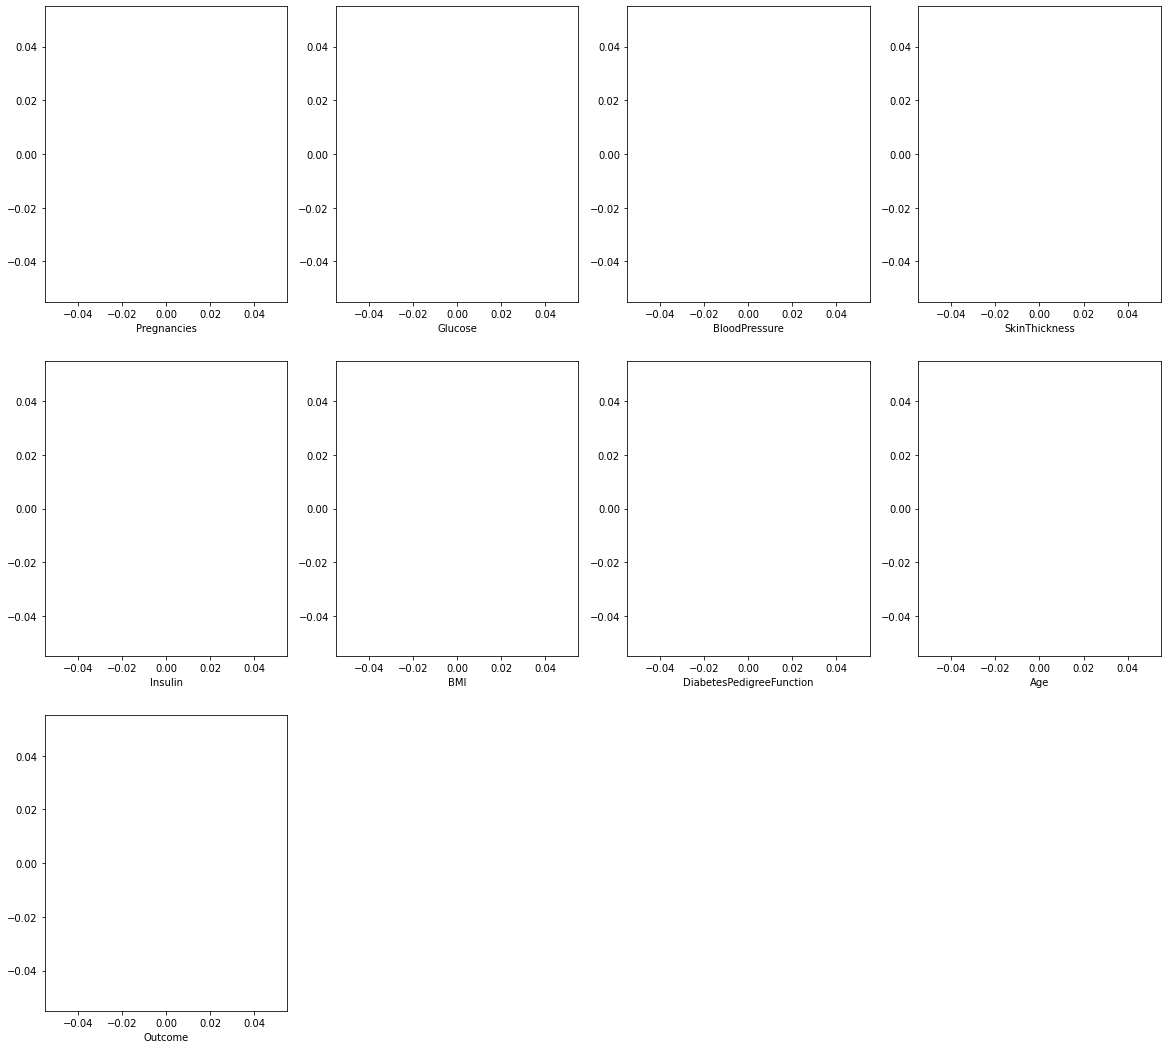

In [19]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25))
plotnumber=1
for column in data_cleaned:
  if plotnumber<=9:
    ax = plt.subplot(4,4,plotnumber)
    sns.distplot(data_cleaned[column])
    plt.xlabel(column)
  plotnumber+=1
    
plt.show()

In [22]:
# features
x = data.drop(columns = ['Outcome'])
y = data['Outcome']

In [23]:
# we need to scale our data as well
scalar = StandardScaler()
x_scaled = scalar.fit_transform(x)

In [24]:
x_scaled

array([[ 0.63994726,  0.86527574, -0.0210444 , ...,  0.16725546,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20598931, -0.51658286, ..., -0.85153454,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01597855, -0.68176235, ..., -1.33182125,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02240928, -0.0210444 , ..., -0.90975111,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14197684, -1.01212132, ..., -0.34213954,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94297153, -0.18622389, ..., -0.29847711,
        -0.47378505, -0.87137393]])

In [25]:
# now we will check for multicollinearity using VIF(Variance Inflation factor)
vif = pd.DataFrame()
#new column
vif["vif"]=[variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif["Features"]=x.columns

In [26]:
#let's check the values
vif

,vif,Features
0,1.431075,Pregnancies
1,1.347308,Glucose
2,1.247914,BloodPressure
3,1.450510,SkinThickness
4,1.262111,Insulin
5,1.550227,BMI
6,1.058104,DiabetesPedigreeFunction
7,1.605441,Age


All the VIF values are less than 5 and are very low. That means no multicollinearity. Now, we can go ahead with fitting our data to the model. Before that, let's split our data in test and training set.

In [29]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.25,random_state=42)

In [30]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [31]:
model.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [32]:
#saving the model
import pickle
with open('gaussiannbmodel.sav','wb') as f:
  pickle.dump(model,f)

#saving scalar 
with open('standardscalar.sav','wb') as f:
  pickle.dump(scalar,f)


In [33]:
y_pred = model.predict(x_test)

In [34]:
y_pred 

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

In [35]:
print(accuracy_score(y_test,y_pred))

0.7291666666666666


In [36]:
#confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[95, 28],
       [24, 45]])

In [39]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [40]:
# Breaking down the formula for Accuracy
# Positive side of the confusion matrix
Accuracy = (true_positive+true_negative)/(true_positive+ false_positive+ false_negative+ true_negative)

In [41]:
Accuracy

0.7291666666666666

In [42]:
# Precision
#correctly prediction in the positive side
Precision = true_positive/ (true_positive + false_positive)

In [43]:
Precision

0.7723577235772358

In [44]:
#Recall
Recall = true_positive/(true_positive+false_negative)

In [45]:
Recall

0.7983193277310925

In [46]:
F1_Score = 2*(Recall*Precision)/(Recall + Precision)

In [47]:
F1_Score

0.7851239669421488

In [48]:
auc = roc_auc_score(y_test,y_pred)

In [49]:
auc

0.7122658183103571